# Explaining Image Drift using Human-Interpretable Features and the K-S Test

## Install Dependencies

In [1]:
# Uncomment when running for the first time
# !pip install alibi-detect
# !pip install opencv-python

In [2]:
from PIL import Image
import numpy as np
import cv2
import io
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import stats
from alibi_detect.utils.perturbation import *
from skimage.restoration import estimate_sigma
import statistics

## Load GTSRB Dataset

In [3]:
import zipfile

! wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

with zipfile.ZipFile('GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
    print('Unzipping...')
    zip_ref.extractall()

! wget -N https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv

--2021-07-12 18:44:55--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘GTSRB_Final_Test_Images.zip’ not modified on server. Omitting download.

Unzipping...
--2021-07-12 18:45:00--  https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-07-12 18:45:00 

In [4]:
X_1 = []
X_2 = []
X_3 = []
X_4 = []

width, height = 64, 64

# total number of images = 12630
for index, file in enumerate(glob.glob('GTSRB/Final_Test/Images/*ppm')):
    image = Image.open(file)
    resized_image = image.resize((width, height))
    np_array = np.array(resized_image)
    if index < 300:
        # Load image file to array:
        X_1.append(np_array)
    elif index < 600:
        X_2.append(np_array)
    elif index < 900:
        X_3.append(np_array)
    elif index < 1200:
        X_4.append(np_array)
        
X_1 = np.asarray(X_1)
X_2 = np.asarray(X_2)
X_3 = np.asarray(X_3)
X_4 = np.asarray(X_4)

## Introduce Corruptions

In [5]:
def motion_blur(images, kernel_size, direction):
    vertical_blurred = []
    horizontal_blurred = []
    for img in images:
        # Specify the kernel size.
        # The greater the size, the more the motion.
        kernel_size = 5

        # Create the vertical kernel.
        kernel_v = np.zeros((kernel_size, kernel_size))

        # Create a copy of the same for creating the horizontal kernel.
        kernel_h = np.copy(kernel_v)

        # Fill the middle row with ones.
        kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
        kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)

        # Normalize.
        kernel_v /= kernel_size
        kernel_h /= kernel_size

        # Apply the vertical kernel.
        vertical_mb = cv2.filter2D(img, -1, kernel_v)

        # Apply the horizontal kernel.
        horizontal_mb = cv2.filter2D(img, -1, kernel_h)
        
        vertical_blurred.append(vertical_mb)
        horizontal_blurred.append(horizontal_mb)
        
    vertical_blurred = np.asarray(vertical_blurred).astype("uint8")
    horizontal_blurred = np.asarray(horizontal_blurred).astype("uint8")
    
    if direction == "vertical":
        return vertical_blurred
    elif direction == "horizontal":
        return horizontal_blurred
    else:
        return
        
def brightness(images, value=30):
    brightened = []
    for img in images:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        brightened.append(img)
    brightened = np.asarray(brightened).astype("uint8")
    return brightened

def speckle_noise(images):
    noisy_images = []
    for img in images:
        row,col,ch = img.shape
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col, ch)        
        noisy = img + img * gauss
        noisy_images.append(noisy)
    noisy_images = np.asarray(noisy_images).astype("uint8")
    return noisy_images

def poisson_noise(images):
    noisy_images = []
    for img in images:
        vals = len(np.unique(img))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(img * vals) / float(vals)
        noisy_images.append(noisy)
    noisy_images = np.asarray(noisy_images).astype("uint8")
    return noisy_images

In [6]:
def plot_images(a, b, title_a, title_b):
    fig = plt.figure(figsize=(10, 7))
    rows, columns = 1, 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(a)
    plt.axis('off')
    plt.title(title_a)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(b)
    plt.axis('off')
    plt.title(title_b)

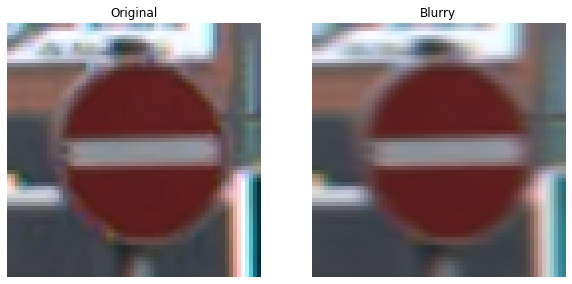

In [7]:
idx = 0
original_img = X_1[idx]
X_blur = motion_blur(X_1, 15, "horizontal")
blurred_img = X_blur[idx]

plot_images(original_img, blurred_img, "Original", "Blurry")

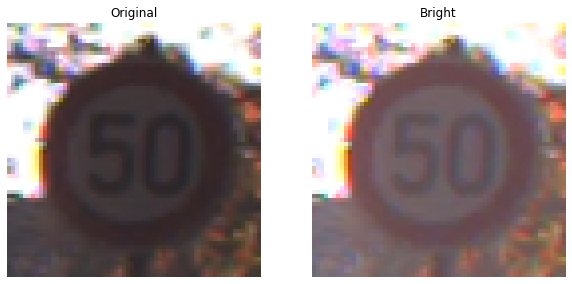

In [8]:
idx = 1
original_img = X_2[idx]
X_bright = brightness(X_2, 50)
bright_img = X_bright[idx]

plot_images(original_img, bright_img, "Original", "Bright")

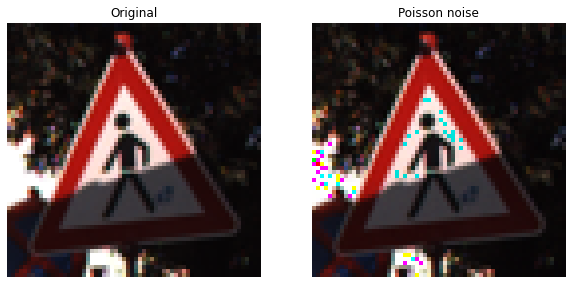

In [9]:
idx = 1
original_img = X_3[idx]
X_noise = poisson_noise(X_3)
noisy_img = X_noise[idx]
plot_images(original_img, noisy_img, "Original", "Poisson noise")

## Compute Image Features and Compare against Baseline Using the K-S Test

In [10]:
# Convert the image to greyscale, apply the Laplacian filter, and find the variance of the pixel values
# A low variance corresponds to a blurry image, and a high variance corresponds to a sharp image
def measure_blur(images):
    variances = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        var = cv2.Laplacian(gray_img, cv2.CV_64F).var()
        variances.append(var)
    return variances

# Convert the image to HSV and find the mean value
def measure_brightness(images):
    brightnesses = []
    for img in images:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mean_value = hsv[...,2].mean()
        brightnesses.append(mean_value)
    return brightnesses

# Return the standard deviation of Gaussian noise
# Higher standard deviation corresponds to more noise, lower corresponds to less noise
def measure_noise(images):
    noises = []
    for img in images:
        noise = estimate_sigma(img, multichannel=True, average_sigmas=True)
        noises.append(noise)
    return noises

def mean(lst):
    mean = sum(lst) / len(lst)
    return mean

def median(lst):
    mid = len(lst) // 2
    lst.sort()
    median = lst[mid]
    return median

### Brightness

As a sanity check, we will print out the mean and median brightnesses for the original dataset and the increased brightness dataset. We can expect the values of the increased brightness dataset to be higher.

In [11]:
original_brightness = measure_brightness(X_1)
original_brightness_2 = measure_brightness(X_2)
increased_brightness = measure_brightness(X_bright)
print(mean(original_brightness), median(original_brightness))
print(mean(original_brightness_2), median(original_brightness_2))
print(mean(increased_brightness), median(increased_brightness))

94.39175944010417 86.325439453125
95.01402750651042 82.6630859375
139.87216471354168 131.961181640625


We will now run the 2 sample Kolmogorov-Smirnov test on the original and corrupted datasets. If the returned p-value is less than the significance level (default = 0.05), we can reject null hypothesis that two samples were drawn from the same distribution. The K-S test will return a p-value < 0.05 when comparing the baseline against the corrupted dataset. On the other hand, the K-S test will return a p-value > 0.05 when comparing two datasets that were not corrupted.

In [12]:
print(stats.ks_2samp(original_brightness, increased_brightness))
print(stats.ks_2samp(original_brightness, original_brightness_2))

KstestResult(statistic=0.3933333333333333, pvalue=4.222383660476908e-21)
KstestResult(statistic=0.07, pvalue=0.4548928024568597)


### Bluriness

We can check the results of bluriness and noise measurements in a similar fashion. As a reminder, a low variance corresponds to a blurry image, and a high variance corresponds to a sharp image.

In [13]:
blurred_variances = measure_blur(X_blur)
original_variances = measure_blur(X_1)
original_variances_2 = measure_blur(X_2)
print(mean(original_variances), median(original_variances))
print(mean(original_variances_2), median(original_variances_2))
print(mean(blurred_variances), median(blurred_variances))

605.0493109140793 232.5078694820404
543.605992637674 214.98730063438416
191.70670339047908 89.40206903219223


In [14]:
print(stats.ks_2samp(original_variances, blurred_variances))
print(stats.ks_2samp(original_variances, original_variances_2))

KstestResult(statistic=0.27, pvalue=5.01791941596116e-10)
KstestResult(statistic=0.04, pvalue=0.9704671760269938)


### Noise

A higher Gaussian noise standard deviation corresponds to more noise, and a lower standard deviation corresponds to less noise.

In [15]:
no_noise = measure_noise(X_3)
no_noise_2 = measure_noise(X_4)
added_noise = measure_noise(X_noise)
print(mean(no_noise), median(no_noise))
print(mean(no_noise_2), median(no_noise_2))
print(mean(added_noise), median(added_noise))

0.9157551536141341 0.6734673497927672
0.96238415106579 0.640362177530679
1.7514839088788283 1.0677583614009494


In [16]:
print(stats.ks_2samp(no_noise, added_noise))
print(stats.ks_2samp(no_noise, no_noise_2))

KstestResult(statistic=0.47, pvalue=2.560690522401642e-30)
KstestResult(statistic=0.05333333333333334, pvalue=0.7879453299387805)


## Explain Drift and Compute Feature Metrics

In [17]:
def explain_drift(x1, x2, significance):
    x1_bright, x2_bright = measure_brightness(x1), measure_brightness(x2)
    x1_blur, x2_blur = measure_blur(x1), measure_blur(x2)
    x1_noise, x2_noise = measure_noise(x1), measure_noise(x2)
    
    drift_violations = {}
    
    stat_bright, p_value_bright = stats.ks_2samp(x1_bright, x2_bright)
    if p_value_bright < significance:
        drift_bright = 1
    else:
        drift_bright = 0
    drift_violations["brightness"] = {"drift": drift_bright, "p_value": p_value_bright}
    
    stat_blur, p_value_blur = stats.ks_2samp(x1_blur, x2_blur)
    if p_value_blur < significance:
        drift_blur = 1
    else:
        drift_blur = 0
    drift_violations["blurriness"] = {"drift": drift_blur, "p_value": p_value_blur}
    
    stat_noise, p_value_noise = stats.ks_2samp(x1_noise, x2_noise)
    if p_value_noise < significance:
        drift_noise = 1
    else:
        drift_noise = 0
    drift_violations["noise"] = {"drift": drift_noise, "p_value": p_value_noise}
    
    return drift_violations

def get_stats(x, normalize = False):
    
    def get_feature_stats(x, normalize):
        
        if normalize:
            x = [el / max(x) for el in x]
        
        x_mean = mean(x)
        x_median = median(x)
        x_min = min(x)
        x_max = max(x)
        x_sd = statistics.stdev(x)
        
        stats = {
            "mean": x_mean,
            "median": x_median,
            "min": x_min,
            "max": x_max,
            "std_dev": x_sd
        }
        
        return stats
        
    x_bright = measure_brightness(x)
    x_blur = measure_blur(x)
    x_noise = measure_noise(x)
    
    brightness_stats = get_feature_stats(x_bright, normalize)
    blurriness_stats = get_feature_stats(x_blur, normalize)
    noise_stats = get_feature_stats(x_noise, normalize)

    combined_stats = {
        "brightness": brightness_stats,
        "bluriness": blurriness_stats,
        "noise": noise_stats
    }

    return combined_stats

### Examine drift results from 2 samples without corruption

Using the results from the 2-sample K-S tests, we can detect whether there is a drift in brightness, blurriness, and noise. We can also add additional features (such as pixelation) if needed. Here we will compare 2 samples drawn from the baseline distribution. Note that no drift is detected.

In [18]:
print("Drift results comparing 2 samples drawn from the baseline distribution:")
print(explain_drift(X_1, X_2, 0.05))

Drift results comparing 2 samples drawn from the baseline distribution:
{'brightness': {'drift': 0, 'p_value': 0.4548928024568597}, 'blurriness': {'drift': 0, 'p_value': 0.9704671760269938}, 'noise': {'drift': 0, 'p_value': 0.8483422371364409}}


In [19]:
print("Statistics for the first sample:")
print(get_stats(X_1))

Statistics for the first sample:
{'brightness': {'mean': 94.39175944010417, 'median': 86.325439453125, 'min': 14.237548828125, 'max': 248.23974609375, 'std_dev': 50.51405563117559}, 'bluriness': {'mean': 605.0493109140793, 'median': 232.5078694820404, 'min': 5.897441625595093, 'max': 6444.762712240219, 'std_dev': 1086.425004795865}, 'noise': {'mean': 0.9804174336261707, 'median': 0.7225308970785235, 'min': 1.1695669281730096e-30, 'max': 6.1450409450566825, 'std_dev': 0.8682717034331013}}


In [20]:
print("Statistics for the second sample:")
print(get_stats(X_2))

Statistics for the second sample:
{'brightness': {'mean': 95.01402750651042, 'median': 82.6630859375, 'min': 14.4365234375, 'max': 249.045654296875, 'std_dev': 54.463892263656874}, 'bluriness': {'mean': 543.605992637674, 'median': 214.98730063438416, 'min': 4.679179906845093, 'max': 6084.395412445068, 'std_dev': 852.531625395008}, 'noise': {'mean': 0.9638683302263371, 'median': 0.6833670577941322, 'min': 1.1695669281730096e-30, 'max': 5.654320147323115, 'std_dev': 0.8424767929489969}}


### Brightness change

Here we will measure drift on a dataset with increased brightness. Note that the noise feature is a general measure; if we are comparing a baseline dataset against a corrupted dataset, noise will be detected. If we are comparing two samples drawn from the original distribution, noise will not be detected.

In [21]:
print("Drift results comparing a bright dataset against an original dataset:")
print(explain_drift(X_1, X_bright, 0.05))

Drift results comparing a bright dataset against an original dataset:
{'brightness': {'drift': 1, 'p_value': 4.222383660476908e-21}, 'blurriness': {'drift': 0, 'p_value': 0.4548928024568597}, 'noise': {'drift': 1, 'p_value': 2.876765319621712e-10}}


In [22]:
print("Baseline statistics:")
print(get_stats(X_1))

Baseline statistics:
{'brightness': {'mean': 94.39175944010417, 'median': 86.325439453125, 'min': 14.237548828125, 'max': 248.23974609375, 'std_dev': 50.51405563117559}, 'bluriness': {'mean': 605.0493109140793, 'median': 232.5078694820404, 'min': 5.897441625595093, 'max': 6444.762712240219, 'std_dev': 1086.425004795865}, 'noise': {'mean': 0.9804174336261707, 'median': 0.7225308970785235, 'min': 1.1695669281730096e-30, 'max': 6.1450409450566825, 'std_dev': 0.8682717034331013}}


In [23]:
print("Bright dataset statistics:")
print(get_stats(X_bright))

Bright dataset statistics:
{'brightness': {'mean': 139.87216471354168, 'median': 131.961181640625, 'min': 64.4365234375, 'max': 254.21337890625, 'std_dev': 47.37365674763813}, 'bluriness': {'mean': 532.7199635883172, 'median': 247.90088438987732, 'min': 10.670869588851929, 'max': 4749.386169433594, 'std_dev': 721.7424068800193}, 'noise': {'mean': 1.2643900957501577, 'median': 1.0396826523327132, 'min': 1.1695669281730096e-30, 'max': 6.030318601916103, 'std_dev': 0.8394365065438874}}


### Blurriness change


In [24]:
print("Drift results comparing a blurry dataset against an original dataset:")
print(explain_drift(X_2, X_blur, 0.05))

Drift results comparing a blurry dataset against an original dataset:
{'brightness': {'drift': 0, 'p_value': 0.4548928024568597}, 'blurriness': {'drift': 1, 'p_value': 7.277526651183985e-09}, 'noise': {'drift': 1, 'p_value': 9.889598198063616e-28}}


In [25]:
print("Baseline statistics:")
print(get_stats(X_2))

Baseline statistics:
{'brightness': {'mean': 95.01402750651042, 'median': 82.6630859375, 'min': 14.4365234375, 'max': 249.045654296875, 'std_dev': 54.463892263656874}, 'bluriness': {'mean': 543.605992637674, 'median': 214.98730063438416, 'min': 4.679179906845093, 'max': 6084.395412445068, 'std_dev': 852.531625395008}, 'noise': {'mean': 0.9638683302263371, 'median': 0.6833670577941322, 'min': 1.1695669281730096e-30, 'max': 5.654320147323115, 'std_dev': 0.8424767929489969}}


In [26]:
print("Blurry dataset statistics:")
print(get_stats(X_blur))

Blurry dataset statistics:
{'brightness': {'mean': 93.90260498046875, 'median': 86.21826171875, 'min': 14.127685546875, 'max': 248.275390625, 'std_dev': 50.399282940216736}, 'bluriness': {'mean': 191.70670339047908, 'median': 89.40206903219223, 'min': 2.949919641017914, 'max': 2247.0842351317406, 'std_dev': 286.7639079374228}, 'noise': {'mean': 0.4446069654588615, 'median': 0.39326180777974235, 'min': 0.0022176260432322376, 'max': 1.8712695558125114, 'std_dev': 0.2170008283020042}}
